In [168]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
from matplotlib import rc

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# frequency information: histogram, cumulant histogram

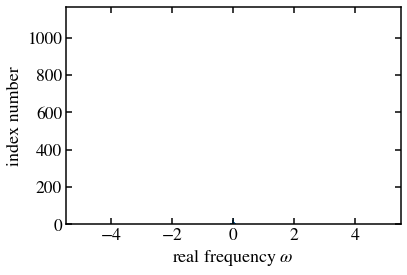

In [2]:
D = 1
out_node = 2
npoint = 2001
N = 10000
directory = '../1_dmftsolver/NRG'
weq = np.linspace(-5, 5, npoint)


w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_41_beta10000/Bethe-{2.25:.3f}.dat', \
                       unpack = True, dtype = 'complex128')

#plt.plot(w.real, np.arange(len(w)))
#plt.xlabel(r'real frequency $\omega$')
#plt.ylabel('cumulant number')
#plt.axhspan(1319-500, 1319+500, alpha=0.5, color='#ffee52')
#plt.annotate(r'$\omega\simeq0$', xy=(0.4, 0.475), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.show()


number, bins, patches = plt.hist(w.real, bins=npoint)
plt.xlabel(r'real frequency $\omega$')
plt.ylabel('index number')
plt.show()

def G(x):
    return np.array([simps(x/(1j*omega[i]-w.real), w) for i in range (N)])
def Geq(x):
    return np.array([simps(x/(1j*omega[i]-weq), weq) for i in range (N)])

def Gmat(x):
    return -np.array([G(xx) for i, xx in enumerate(x)])/np.pi
def Geqmat(x):
    return -np.array([Geq(xx) for i, xx in enumerate(x)])/np.pi

omega = np.pi/10000 * (2*np.arange(N)+1) # w_n
iwnumber = -Geq(number).imag/np.pi

#plt.plot(omega, iwnumber)
#plt.xlabel(r'imag frequency $i\omega_n$')
#plt.ylabel('index number')
#plt.yscale('log')

# Data: NRG, ED

In [3]:
beta = 10000
U_c1_4, U_c2_4 = 2.25, 2.9
    
w_len = len(np.loadtxt(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

up_num = 142
dn_num = 129

U = np.array([0.001*i for i in range(500, 5001)])
U1_4 = np.zeros(up_num, dtype = 'float64')
U2_4 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_4[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/Bethe_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_4[n] = u
    n += 1

x_test_iw_up = np.zeros((len(U1_4), 10000), dtype = 'float64')
x_test_iw_dn = np.zeros((len(U2_4), 10000), dtype = 'float64')
for i,u in enumerate(U1_4):
    iw, Giw_r, Giw_i = np.loadtxt(f'../1_dmftsolver/NRG/A_to_Giw/NRG/B_14_beta{beta:d}/Bethe-Giw-{u:.3f}.dat',\
                                       unpack = True, dtype = 'float64')
    x_test_iw_up[i] = (D/2)**2 * Giw_i
for i,u in enumerate(U2_4):
    iw, Giw_r, Giw_i = np.loadtxt(f'../1_dmftsolver/NRG/A_to_Giw/NRG/B_41_beta{beta:d}/Bethe-Giw-{u:.3f}.dat',\
                                       unpack = True, dtype = 'float64')
    x_test_iw_dn[i] = (D/2)**2 * Giw_i
x_test_iw_up = torch.FloatTensor(-x_test_iw_up)
x_test_iw_dn = torch.FloatTensor(-x_test_iw_dn)

y_temp1 = np.array(U1_4 < U_c2_4)
y_temp2 = np.array(U2_4 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_4 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_4 = torch.FloatTensor(y_test_4)
#UU_4 = np.concatenate((U1_4, U2_4))

In [4]:
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (N)])

beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93

U = np.array([0.01*i for i in range(50, 501)])
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed_up = np.zeros((len(U1_ed), 10000), dtype = 'float64')
x_test_ed_dn = np.zeros((len(U2_ed), 10000), dtype = 'float64')
for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed_up[i][:N] = EDbath(e,V).imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed_dn[i][:N] = EDbath(e,V).imag
x_test_ed_up = torch.FloatTensor(-x_test_ed_up)
x_test_ed_dn = torch.FloatTensor(-x_test_ed_dn)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)
UU_ed = np.concatenate((U1_ed, U2_ed))

# To bring frozen Neural Network Model

In [5]:
class LRNet(nn.Module):
    def __init__(self, activate = None):
        super(LRNet, self).__init__()
        self.W1 = nn.Linear(10000, out_node)#, bias=False)
        self.b1 = nn.Linear(out_node, 1)#, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        
        W1_ = np.loadtxt('frozen_mat/LR_W1_iw.txt', dtype='float64')
        b1_ = np.loadtxt('frozen_mat/LR_b1.txt', dtype='float64')
        self.W1.weight.data = torch.FloatTensor(W1_)
        self.b1.weight.data = torch.FloatTensor(b1_)

    def forward(self, x):
        x = self.W1(x)+self.b1.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)
    
    
class NN10Net(nn.Module):
    def __init__(self, activate = None):
        super(NN10Net, self).__init__()
        self.W1 = nn.Linear(10000, 10)#, bias=False)
        self.b1 = nn.Linear(10, 1, bias=False)
        self.W2 = nn.Linear(10, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        
        W1_ = np.loadtxt('frozen_mat/NN10_W1_iw.txt', dtype='float64')
        b1_ = np.loadtxt('frozen_mat/NN10_b1.txt', dtype='float64')
        W2_ = np.loadtxt('frozen_mat/NN10_W2.txt', dtype='float64')
        b2_ = np.loadtxt('frozen_mat/NN10_b2.txt', dtype='float64')
        self.W1.weight.data = torch.FloatTensor(W1_)
        self.W2.weight.data = torch.FloatTensor(W2_)
        self.b1.weight.data = torch.FloatTensor(b1_)
        self.b2.weight.data = torch.FloatTensor(b2_)
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

class NN100Net(nn.Module):
    def __init__(self, activate = None):
        super(NN100Net, self).__init__()
        self.W1 = nn.Linear(10000, 100)#, bias=False)
        self.b1 = nn.Linear(100, 1, bias=False)
        self.W2 = nn.Linear(100, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        
        W1_ = np.loadtxt('frozen_mat/NN100_W1_iw.txt', dtype='float64')
        b1_ = np.loadtxt('frozen_mat/NN100_b1.txt', dtype='float64')
        W2_ = np.loadtxt('frozen_mat/NN100_W2.txt', dtype='float64')
        b2_ = np.loadtxt('frozen_mat/NN100_b2.txt', dtype='float64')
        self.W1.weight.data = torch.FloatTensor(W1_)
        self.W2.weight.data = torch.FloatTensor(W2_)
        self.b1.weight.data = torch.FloatTensor(b1_)
        self.b2.weight.data = torch.FloatTensor(b2_)
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [6]:
func = nn.Sigmoid
LRmodel = LRNet(activate = func)
NN10model = NN10Net(activate = func)
NN100model = NN100Net(activate = func)

In [7]:
matdir='./frozen_mat'
W1_LR = np.loadtxt(f'{matdir}/LR_W1.txt', dtype='float64')
W1_NN10 = np.loadtxt(f'{matdir}/NN10_W1.txt', dtype='float64')
W1_NN100 = np.loadtxt(f'{matdir}/NN100_W1.txt', dtype='float64')
W2_NN10 = np.loadtxt(f'{matdir}/NN10_W2.txt', dtype='float64')
W2_NN100 = np.loadtxt(f'{matdir}/NN100_W2.txt', dtype='float64')

reW1_LR = np.loadtxt(f'{matdir}/LR_W1_re.txt', dtype='float64')
reW1_NN10 = np.loadtxt(f'{matdir}/NN10_W1_re.txt', dtype='float64')
reW1_NN100 = np.loadtxt(f'{matdir}/NN100_W1_re.txt', dtype='float64')

iwW1_LR = np.loadtxt(f'{matdir}/LR_W1_iw.txt', dtype='float64')
iwW1_NN10 = np.loadtxt(f'{matdir}/NN10_W1_iw.txt', dtype='float64')
iwW1_NN100 = np.loadtxt(f'{matdir}/NN100_W1_iw.txt', dtype='float64')

# Figure 3. Matrix representation & heatmap

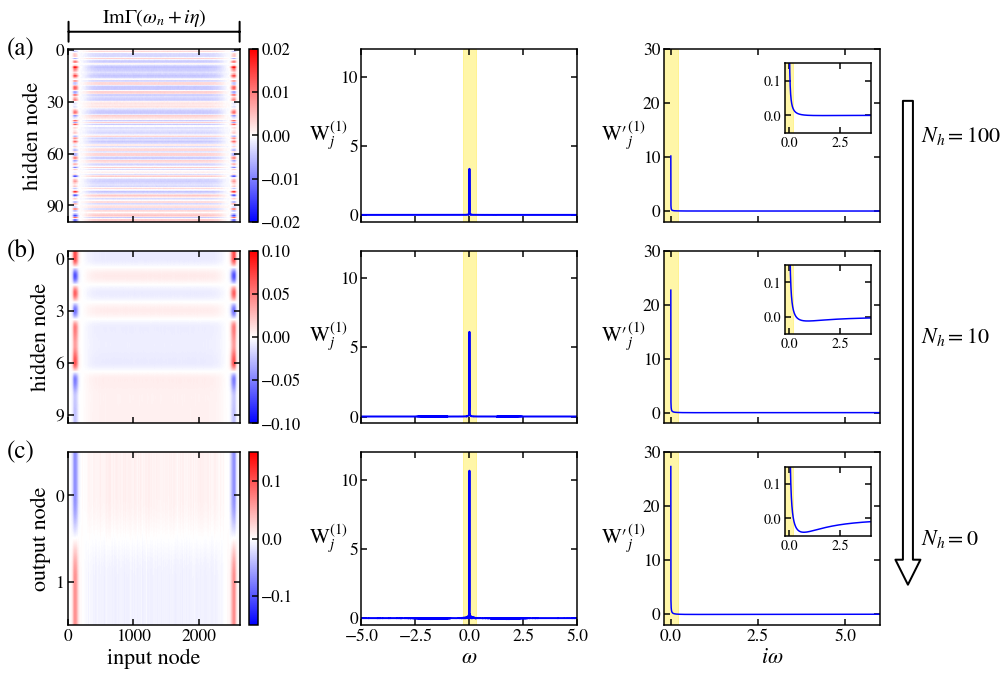

In [169]:
a = 0.05
ax00 = plt.axes([0.2+a, 1.4, 0.4, 0.6])
ax10 = plt.axes([0.2+a, 0.7, 0.4, 0.6])
ax20 = plt.axes([0.2+a, 0.0, 0.4, 0.6])
ax01 = plt.axes([0.88+a, 1.4, 0.5, 0.6])
ax11 = plt.axes([0.88+a, 0.7, 0.5, 0.6])
ax21 = plt.axes([0.88+a, 0.0, 0.5, 0.6])
ax02 = plt.axes([1.58+a, 1.4, 0.5, 0.6])
ax12 = plt.axes([1.58+a, 0.7, 0.5, 0.6])
ax22 = plt.axes([1.58+a, 0.0, 0.5, 0.6])
ax03 = plt.axes([1.86+a, 1.41+0.3, 0.2, 0.24])
ax13 = plt.axes([1.86+a, 0.71+0.3, 0.2, 0.24])
ax23 = plt.axes([1.86+a, 0.01+0.3, 0.2, 0.24])


im00 = ax00.imshow(W1_NN100, aspect=2638/100, cmap='bwr', **{'vmin':-0.02, 'vmax':0.02})
im10 = ax10.imshow(W1_NN10, aspect=2638/10, cmap='bwr', **{'vmin':-0.10, 'vmax':0.10})
im20 = ax20.imshow(W1_LR, aspect=2638/2, cmap='bwr', **{'vmin':-0.15, 'vmax':0.15})
ax00.yaxis.set_major_locator(ticker.MultipleLocator(30))
ax10.yaxis.set_major_locator(ticker.MultipleLocator(3))
ax20.yaxis.set_major_locator(ticker.MultipleLocator(1))
cax0=inset_axes(ax00, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax00.transAxes, borderpad=0)
cax1=inset_axes(ax10, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax10.transAxes, borderpad=0)
cax2=inset_axes(ax20, width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax20.transAxes, borderpad=0)
cd = plt.colorbar(im00, cax=cax0)
cd.ax.tick_params(labelsize=16.5)
cd = plt.colorbar(im10, cax=cax1)
cd.ax.tick_params(labelsize=16.5)
cd = plt.colorbar(im20, cax=cax2)
cd.ax.tick_params(labelsize=16.5)
ax00.annotate('', xy=(0.005, 1.1), xytext=(0.995, 1.1), xycoords='axes fraction',\
                 ha='center', va="center", \
                 arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0, 'lw':2})
ax00.annotate(r'Im$\Gamma(\omega_n+i\eta)$', xy=(0.5, 1.15), xycoords = 'axes fraction', fontsize=20, ha='center')
ax00.set_ylabel('hidden node', fontsize=22)
ax10.set_ylabel('hidden node', fontsize=22)
ax20.set_ylabel('output node', fontsize=22)
ax20.set_xlabel('input node', fontsize=22)

ax01.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax11.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax21.axvspan(-0.32, +0.3, alpha=0.5, color='#ffee52')
ax01.plot(weq, (number*reW1_NN100)[20], lw=2, c='b')
ax11.plot(weq, (number*reW1_NN10)[9], lw=2, c='b')
ax21.plot(weq, (number*reW1_LR)[0], lw=2, c='b')
ax01.set_xlim(-5,5), ax11.set_xlim(-5,5), ax21.set_xlim(-5,5)
ax01.set_ylim(-0.5,12), ax11.set_ylim(-0.5,12), ax21.set_ylim(-0.5,12)
ax01.set_xticks([-5, -2.5, 0, 2.5, 5])
ax11.set_xticks([-5, -2.5, 0, 2.5, 5])
ax21.set_xticks([-5, -2.5, 0, 2.5, 5])
ax10.set_xticklabels([]), ax00.set_xticklabels([])
ax11.set_xticklabels([]), ax01.set_xticklabels([])
ax12.set_xticklabels([]), ax02.set_xticklabels([])

ax21.set_xlabel(r'$\omega$', fontsize=22)
ax01.set_ylabel(r'$\mathrm{W}^{(1)}_{j}$', rotation=0, labelpad=12, va='center', fontsize=21)
ax11.set_ylabel(r'$\mathrm{W}^{(1)}_{j}$', rotation=0, labelpad=12, va='center', fontsize=21)
ax21.set_ylabel(r'$\mathrm{W}^{(1)}_{j}$', rotation=0, labelpad=12, va='center', fontsize=21)
#ax21.set_xticklabels([])


ax02.plot(omega[:], (iwW1_NN100)[20][:], lw=1.5, c='b')
ax12.plot(omega[:], (iwW1_NN10)[9][:], lw=1.5, c='b')
ax22.plot(omega[:], (iwW1_LR)[0][:], lw=1.5, c='b')
ax02.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax12.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax22.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax02.set_xlim(-0.2,6), ax12.set_xlim(-0.2,6), ax22.set_xlim(-0.2,6)
ax02.set_ylim(-2,30), ax12.set_ylim(-2,30), ax22.set_ylim(-2,30)
ax02.set_xticks([0, 2.5, 5]), ax02.set_xticklabels([])
ax12.set_xticks([0, 2.5, 5]), ax12.set_xticklabels([])
ax22.set_xticks([0, 2.5, 5])

ax03.plot(omega[:], (iwW1_NN100)[20][:], lw=1.5, c='b')
ax13.plot(omega[:], (iwW1_NN10)[9][:], lw=1.5, c='b')
ax23.plot(omega[:], (iwW1_LR)[0][:], lw=1.5, c='b')
ax03.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax13.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax23.axvspan(-0.2, +0.2, alpha=0.5, color='#ffee52')
ax03.set_xlim(-0.2,4), ax13.set_xlim(-0.2,4), ax23.set_xlim(-0.2,4)
ax03.set_ylim(-0.05,0.15), ax13.set_ylim(-0.05,0.15), ax23.set_ylim(-0.05,0.15)
ax03.tick_params(labelsize=14), ax13.tick_params(labelsize=14), ax23.tick_params(labelsize=14)
ax22.set_xlabel(r'$i\omega$', fontsize=22)
ax02.set_ylabel(r'$\mathrm{W}\prime^{(1)}_{j}$', rotation=0, labelpad=20, va='center', fontsize=21)
ax12.set_ylabel(r'$\mathrm{W}\prime^{(1)}_{j}$', rotation=0, labelpad=20, va='center', fontsize=21)
ax22.set_ylabel(r'$\mathrm{W}\prime^{(1)}_{j}$', rotation=0, labelpad=20, va='center', fontsize=21)


plt.gcf().text(0.11, 2.0-0.02, '(a)', fontsize = 25)
plt.gcf().text(0.11, 1.3-0.02, '(b)', fontsize = 25)
plt.gcf().text(0.11, 0.6-0.02, '(c)', fontsize = 25)
ax01.annotate('', xy=(2.53,-2.1), xytext=(2.53,0.7), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
plt.gcf().text(1.19, 0.5, r'$N_h=100$', fontsize = 22, \
          ha='left',va='center', transform = ax02.transAxes)
plt.gcf().text(1.19, 0.5, r'$N_h=10$', fontsize = 22, \
          ha='left',va='center', transform = ax12.transAxes)
plt.gcf().text(1.19, 0.5, r'$N_h=0$', fontsize = 22, \
          ha='left',va='center', transform = ax22.transAxes)
plt.savefig('fig3_temp.pdf', bbox_inches='tight')